<a href="https://colab.research.google.com/github/mbajdman/Data-Science-Portfolio/blob/main/AB_Testing_Email_Sign_Up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A/B Testing Email Sign-Up

This project focuses on an A/B test conducted for Urban Wear, a fictional online fashion retailer. The objective of the test was to evaluate the impact of changing the colour of the sign-up button on the pre-launch page. By comparing the sign-up rates for the original blue button and a proposed green button, we aimed to determine if this seemingly minor design change could lead to a significant improvement in user conversions.

 **Does changing the colour of the sign-up button from blue to green result in a higher sign-up rate on the Urban Wear pre-launch page?**

The findings of this A/B test will provide valuable insights for Urban Wear's marketing and design teams, informing future website optimisation strategies and ultimately contributing to business growth. This report presents a comprehensive overview of the experiment, including its methodology, results, and conclusions, along with recommendations for action.

In [1]:
from datetime import datetime
import random
import math

import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from statsmodels.stats.power import TTestIndPower, tt_ind_solve_power
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.proportion import proportions_chisquare, confint_proportions_2indep

from google.colab import drive
drive.mount('/content/drive/')

# Disable warnings
from warnings import filterwarnings
filterwarnings('ignore')

# Set seed for np random
SEED = 123
np.random.seed(SEED)

Mounted at /content/drive/


In [2]:
# Set data path and load data
data_path = '/content/drive/MyDrive/Colab Notebooks/AB Testing/'
pretest = pd.read_csv(data_path+'pretest.csv'); print('Pretest Data Imported!')
test = pd.read_csv(data_path+'test.csv'); print('Test Data Imported!')

# Set date fields as date_time
pretest['date'] = pd.to_datetime(pretest['date'])
test['date'] = pd.to_datetime(test['date'])

Pretest Data Imported!
Test Data Imported!


# 1. Understand the Business Problem

The first step in AB testing is to understand the business problem.

## Table Summary

In [3]:
# Display the first five rows
pretest.head()

,visitor_id,date,email,experiment,group,submitted
0,1,2021-12-01,NaN,NaN,NaN,0
1,2,2021-12-01,NaN,NaN,NaN,0
2,3,2021-12-01,NaN,NaN,NaN,0
3,4,2021-12-01,NaN,NaN,NaN,0
4,5,2021-12-01,NaN,NaN,NaN,0


* Visitor_id is a unique value assigne to each visitor of pre-launch website.
* Date is actual date of visiting website.
* The email is `Null` if visitor did not submit any email.
* Experiment field indicates whether visitor was assigned to experiment, those could be three values, `Null` meaning no assigment, `AA` or `AB` test.
* Group means whether the visitor was assigned to `control-0` or `treatment-1` (experiment).
* Submitted - `0-no submission` of email, `1-submission`

###Data pre-check

In [4]:
# Show stats about the pretest table

# A. How many rows are in the table?
# B. What's the date range of the date field in the table?

print('# of rows:', pretest.shape[0])
print('Date range:', pretest.date.min(), '-', pretest.date.max())

# of rows: 309903
Date range: 2021-12-01 00:00:00 - 2021-12-31 00:00:00


In [5]:
# Check for missingness. What's the null rate per column?
pretest.isnull().mean()

,0
visitor_id,0.000000
date,0.000000
email,0.899017
experiment,0.903070
group,0.903070
submitted,0.000000


In [6]:
# Stats about the pretest performance

# A. Number of visitors
# B. Number of sign-ups
# C. Sign-up rate

print('Total visitor count:', pretest.visitor_id.nunique())
print('Sign-up count:', pretest.submitted.sum())
print('Sign-up rate:', pretest.submitted.mean().round(2))

Total visitor count: 309903
Sign-up count: 31295
Sign-up rate: 0.1


## Plot Visitor per Day

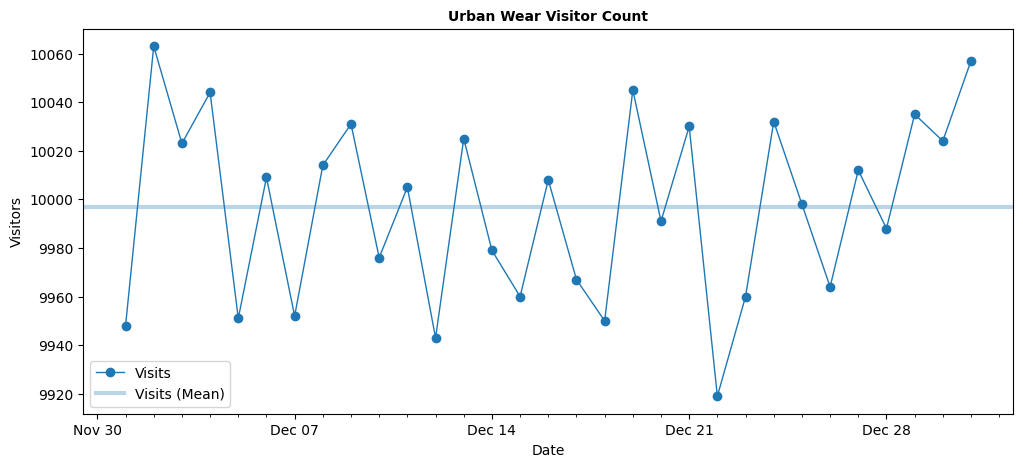

In [7]:
# Set the color palette for the plot
colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

# Count sign-ups by date
visits_per_day = pretest.groupby('date')['submitted'].count()
visits_mean = visits_per_day.mean()

# Plot data
f, ax = plt.subplots(figsize=(12, 5))
plt.plot(visits_per_day.index, visits_per_day, '-o', color=c1, linewidth=1, label='Visits')
plt.axhline(visits_mean, color=c1, linestyle='-', linewidth=3, alpha=0.3, label='Visits (Mean)')

# Format plot
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
ax.xaxis.set_minor_locator(mdates.DayLocator())
plt.title('Urban Wear Visitor Count', fontsize=10, weight='bold')
plt.ylabel('Visitors', fontsize=10)
plt.xlabel('Date', fontsize=10)
plt.legend()

plt.show()

We see that global mean is `10000` visitors per day. It gives us a sense of volume of traffic and what the percent alocation could be when determining experimentation time.

This gives us information what the experiment duration should be.

## Plot Sign-Up Rate per Day

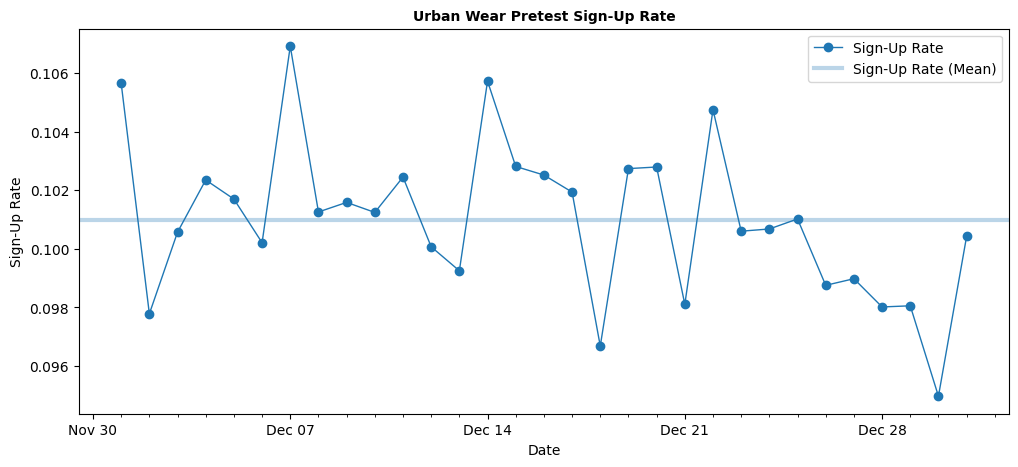

In [8]:
# Get the submission rate per date
signup_rate_per_day = pretest.groupby('date')['submitted'].mean() # when we apply mean to 0 or 1 it gets us a rate
signup_rate_mean = signup_rate_per_day.mean()

# Plot data
f, ax = plt.subplots(figsize=(12, 5))
plt.plot(signup_rate_per_day.index, signup_rate_per_day, '-o', color=c1, linewidth=1, label='Sign-Up Rate')
plt.axhline(signup_rate_mean, color=c1, linestyle='-', linewidth=3, alpha=0.3, label='Sign-Up Rate (Mean)')

# Format plot
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
ax.xaxis.set_minor_locator(mdates.DayLocator())
plt.title('Urban Wear Pretest Sign-Up Rate', fontsize=10, weight='bold')
plt.ylabel('Sign-Up Rate', fontsize=10)
plt.xlabel('Date', fontsize=10)
plt.legend()
plt.show()

This shows us what is the current performance to beat and what could be the `minimum detctable effect (MDE)` that would be deemed as pratical significant for the business.

#2. Hypothesis Statement

The second step of the experiment is to state:
* The hypothesis
* Significance level (alpha)
* Statistical power
* Minimum detctable effect (MDE).

**Ho:** The sign-up rates of blue and green buttons are the same.<br>
**Ha:** The sign-up rates of blue and green buttons are different.

In [9]:
# Experiment parameters
alpha = 0.05  # Set the probability threshold at 0.05. If the p-value is less than 0.05, reject Ho.
power = 0.80  # Ensure that there's 80% chance of detecting an effect with significance
mde = 0.10    # Detect a 10% improvement of the sign-up rate with statistical significance

# Proportions if the effect exists
p1 = 0.10           # Control   (Blue)
p2 = p1 * (1 + p1)  # Treatment (Green)

# 3. Design the Experiment

The third step is the design of the experiment which involves:
* Determining the randomization unit
* Calculating the sample size
* Determining the experiment duration.

#### Calculate Sample Size

To detect an effect of 10.0% lift from the pretest sign-up at 10%, the sample size per group required is 15000.
The total sample required in the experiment is 30000.


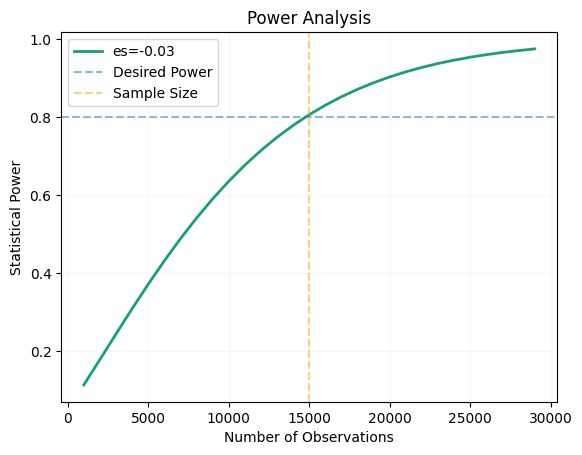

In [10]:
# Calculate the effect size using Cohen's D
cohen_D = sm.stats.proportion_effectsize(p1, p2)

# Estimate the sample size required per group
n = tt_ind_solve_power(effect_size=cohen_D, power=power, alpha=alpha)
n = int(round(n, -3)) # Round up to the nearest thousand

print(f'To detect an effect of {100*(p2/p1-1):.1f}% lift from the pretest sign-up at {100*p1:.0f}%, '
      f'the sample size per group required is {n}.'
      f'\nThe total sample required in the experiment is {2*n}.')

# Explore power across sample sizes
ttest_power = TTestIndPower()
ttest_power.plot_power(dep_var='nobs', nobs=np.arange(1000,30000,1000), effect_size=[cohen_D], title='Power Analysis')

# Set plot parameters
plt.axhline(0.8, linestyle='--', label='Desired Power', alpha=0.5)
plt.axvline(n, linestyle='--', color='orange', label='Sample Size', alpha=0.5)
plt.ylabel('Statistical Power')
plt.grid(alpha=0.08)
plt.legend()
plt.show()

#### Experiment Duration

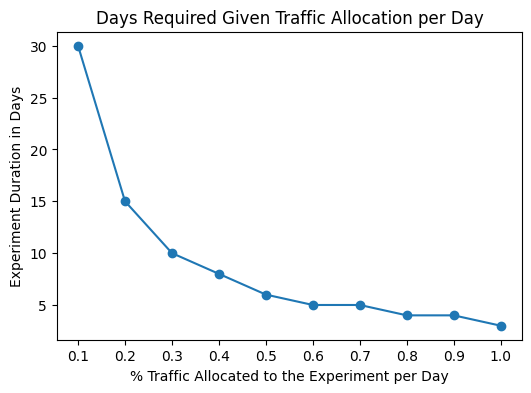

In [11]:
# what's the duration to achieve the required sample size given the
# percentage of unique visitors allocated to the experiment?

allocations = np.arange(0.10,1.1,0.10)
daily_samples = round(visits_mean, -3) * allocations
days = np.ceil(2*n / daily_samples)

# Generate plot
f, ax = plt.subplots(figsize=(6, 4))
ax.plot(allocations, days, '-o')

# Format
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.set_title('Days Required Given Traffic Allocation per Day')
ax.set_ylabel('Experiment Duration in Days')
ax.set_xlabel('% Traffic Allocated to the Experiment per Day')
plt.show()

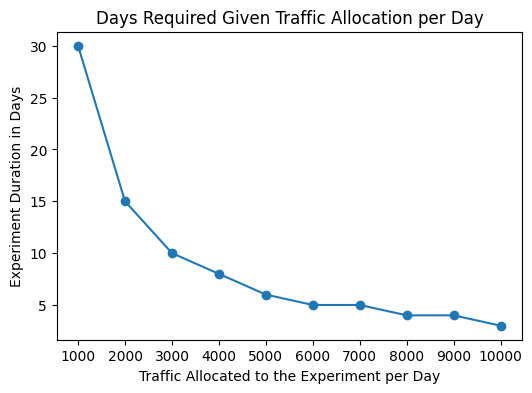

In [13]:
# what's the duration required to achieve the required sample size given the
# number of unique visitors allocated to the experiment?

f, ax = plt.subplots(figsize=(6, 4))
ax.plot(daily_samples, days, '-o')
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.set_title('Days Required Given Traffic Allocation per Day')
ax.set_ylabel('Experiment Duration in Days')
ax.set_xlabel('Traffic Allocated to the Experiment per Day')
plt.show()

In [14]:
# Display the number of users required per day in an experiment given the experiment duration.
print(f'For a 21-day experiment, {np.ceil(n * 2 / 21)} users are required per day') # Too long to wait
print(f'For a 14-day experiment, {np.ceil(n * 2 / 14)} users are required per day') # Sweet spot between risk and time
print(f'For a 7-day experiment, {np.ceil(n * 2 / 7)} users are required per day')   # Too risky

For a 21-day experiment, 1429.0 users are required per day
For a 14-day experiment, 2143.0 users are required per day
For a 7-day experiment, 4286.0 users are required per day


# 4. Assess Validity Threats

We will check for two of the checks for validity threats, which involve the `AA` test and the `Chi-Square` test for `Sample Ratio Mismatch (SRM)`.

Conducting checks for the experiment ensures that the AB test result is trustworthy and reduces risk of committing `Type I` or `II` errors.

We run an AA test to ensure that there is no underlying difference between
the control and treatment to begin with.

We run a chi-square test on group sizes to check for sample-ratio mismatch (SRM). This test ensures that the randomization algorithm worked

There are other potential checks that could be performed including segmentation analysis, novelty checks and so on.

## AA Test

We run this in a similar way as `AB` test. We randomly assigned the fraction of the user into an experiment and we alocate them either into the control & treatment group. In `AA` test the control & treatment are not exposed to difference conditon, in fact to the same baseline condition. We want to ensure both groups of user are the same from the go.

In [15]:
# Let's conduct an AA test

# Filter on visitors in the AA test
AA_test = pretest[pretest.experiment == 'AA_test']

# Grab the control and treatment groups in the AA test
AA_control = AA_test[AA_test.group == 0]['submitted']
AA_treatment = AA_test[AA_test.group == 1]['submitted']

# Get stats
AA_control_cnt = AA_control.sum()
AA_treatment_cnt = AA_treatment.sum()
AA_control_rate = AA_control.mean()
AA_treatment_rate = AA_treatment.mean()
AA_control_size = AA_control.count()
AA_treatment_size = AA_treatment.count()

# Show calculation
print('-------- AA Test ----------')
print(f'Control Sign-Up Rate: {AA_control_rate:.3}')
print(f'Treatment Sign-Up Rate: {AA_treatment_rate:.3}')

-------- AA Test ----------
Control Sign-Up Rate: 0.101
Treatment Sign-Up Rate: 0.0988


Let's look at how `sign-up` rates fluctuate on a per day basis over course of running `AA` test.

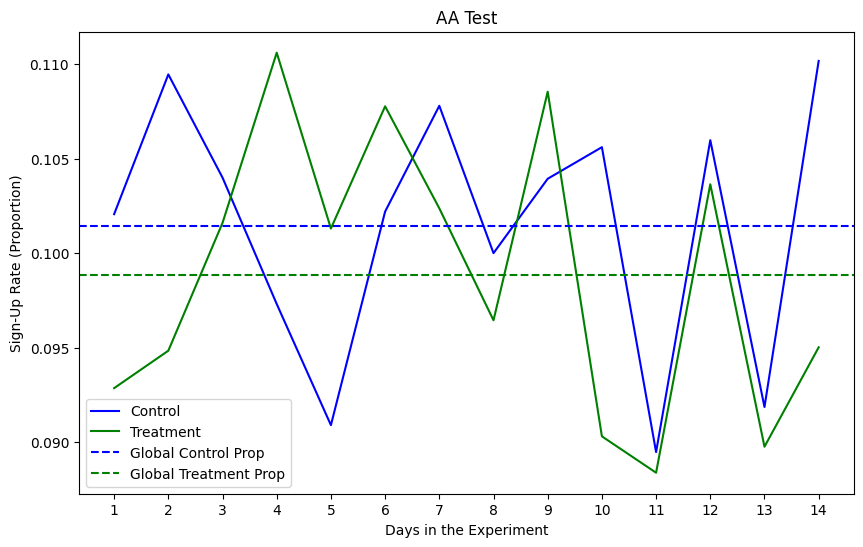

In [16]:
# Sign-up rates per date
AA_signups_per_day = AA_test.groupby(['group','date'])['submitted'].mean()
AA_ctrl_props = AA_signups_per_day.loc[0]
AA_trt_props = AA_signups_per_day.loc[1]

# Get the day range of experiment
exp_days = range(1, AA_test['date'].nunique() + 1)

# Let's display the sign-up rate per experiment day
f, ax = plt.subplots(figsize=(10, 6))
# Generate plots
ax.plot(exp_days, AA_ctrl_props, label='Control', color='b')
ax.plot(exp_days, AA_trt_props, label='Treatment', color='g')
ax.axhline(AA_control_rate, label='Global Control Prop', linestyle='--', color='b')
ax.axhline(AA_treatment_rate, label='Global Treatment Prop', linestyle='--', color='g')

# # Format plot
ax.set_xticks(exp_days)
ax.set_title('AA Test')
ax.set_ylabel('Sign-Up Rate (Proportion)')
ax.set_xlabel('Days in the Experiment')
ax.legend()
plt.show()

The sing-up rates are approximatelly the same, that's what we want in `AA` test. Let's validate it with statistical inference and use proportion `Chi-Square Test`. We should expect null hypothesis.

In [17]:
# Run a chi-square test

# Execute test
AA_chistats, AA_pvalue, AA_tab = proportions_chisquare([AA_control_cnt, AA_treatment_cnt], nobs=[AA_control_size, AA_treatment_size])

# Grab dates
first_date = AA_test['date'].min().date()
last_date = AA_test['date'].max().date()

# Set the ALPHA for the AA test
AA_ALPHA = 0.05

print(f'-------- AA Test ({first_date} - {last_date})---------\n')
print('Ho: The sign-up rates between blue and green are the same.')
print('Ha: The sign-up rates between blue and green are different.\n')
print(f'Significance level: {AA_ALPHA}')

print(f'Chi-Square = {AA_chistats:.3f} | P-value = {AA_pvalue:.3f}')

print('\nConclusion:')
if AA_pvalue < AA_ALPHA:
  print('Reject Ho and conclude that there is statistical significance in the difference between the two groups. Check for instrumentation errors.')
else:
  print('Fail to reject Ho. Therefore, proceed with the AB test.')

-------- AA Test (2021-12-18 - 2021-12-31)---------

Ho: The sign-up rates between blue and green are the same.
Ha: The sign-up rates between blue and green are different.

Significance level: 0.05
Chi-Square = 0.577 | P-value = 0.448

Conclusion:
Fail to reject Ho. Therefore, proceed with the AB test.


## Sample Ratio Mismatch (SRM)

There's a randomisation algorithm that determines whether the user should be assigned to control of treatment. Even if we set the sample size per group to `15000`. it does not mean the actual sample size at the end of the experiment is going to be exactly `15000`. There could potentially be some discrepancies. As the gap gets greater and greater that might indicate the randomisation algorithm is faulty.

To check this let's run `Chi-Square Goodness of Fit Test` that expects that sample sizes between groups are the same.

In [18]:
# Let's check for sample ratio mismatch (SRM)

# Set test param
SRM_ALPHA = 0.05

# Get the observed and expected counts in the experiment
email_test = test[test.experiment == 'email_test']
observed = email_test.groupby('group')['experiment'].count().values
expected = [email_test.shape[0]*0.5]*2

# perform Chi-Square Goodness of Fit Test
chi_stats, pvalue = stats.chisquare(f_obs=observed, f_exp=expected)

print('------- A Chi-Square Test for SRM --------\n')
print('Ho: The ratio of samples is 1:1.')
print('Ha: The ratio of samples is not 1:1.\n')
print(f'Significance level: {SRM_ALPHA}')

print(f'Chi-Square = {chi_stats:.3f} | P-value = {pvalue:.3f}')

print('\nConclusion:')
if pvalue < SRM_ALPHA:
  print('Reject Ho and conclude that there is statistical significance in the ratio of samples not being 1:1. Therefore, there is SRM.')
else:
  print('Fail to reject Ho. Therefore, there is no SRM.')

------- A Chi-Square Test for SRM --------

Ho: The ratio of samples is 1:1.
Ha: The ratio of samples is not 1:1.

Significance level: 0.05
Chi-Square = 1.290 | P-value = 0.256

Conclusion:
Fail to reject Ho. Therefore, there is no SRM.


# 5. Run the Experiment

We will take a look at the step that involves running an experiment. The code below a simplified version of how data is collected and analyzed in a large scale experiment platform.

In [19]:
# Get the subset tables of control and treatment results
AB_test = test[test.experiment == 'email_test']
control_signups = AB_test[AB_test.group == 0]['submitted']
treatment_signups = AB_test[AB_test.group == 1]['submitted']

# Get stats
AB_control_cnt = control_signups.sum()          # Control Sign-Up Count
AB_treatment_cnt = treatment_signups.sum()      # Treatment Sign-Up Count
AB_control_rate = control_signups.mean()        # Control Sign-Up Rate
AB_treatment_rate = treatment_signups.mean()    # Treatment Sign-Up Rate
AB_control_size = control_signups.count()       # Control Sample Size
AB_treatment_size = treatment_signups.count()   # Treatment Sample Size

# Show calculation
print(f'Control Sign-Up Rate: {AB_control_rate:.4}')
print(f'Treatment Sign-Up Rate: {AB_treatment_rate:.4}')

Control Sign-Up Rate: 0.09557
Treatment Sign-Up Rate: 0.1078


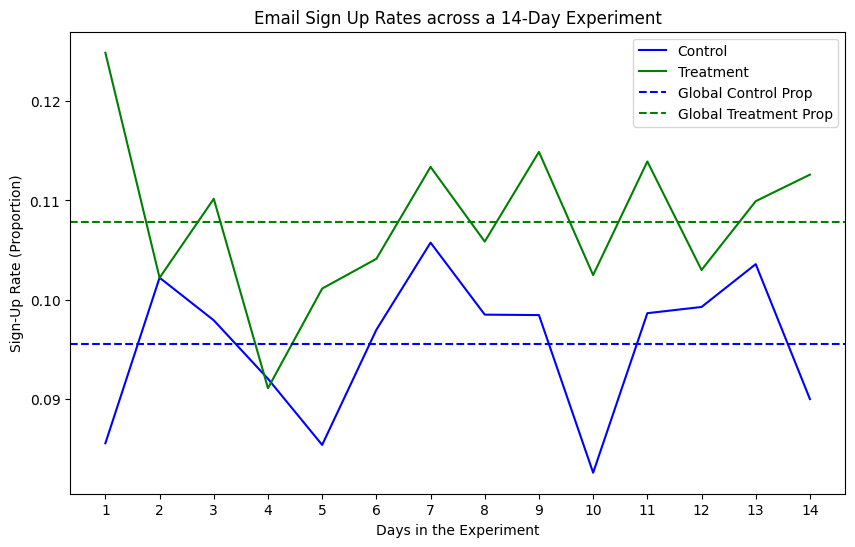

In [20]:
# Calculate the sign-up rates per date
signups_per_day = AB_test.groupby(['group','date'])['submitted'].mean()
ctrl_props = signups_per_day.loc[0]
trt_props = signups_per_day.loc[1]

# Get the day range of experiment
exp_days = range(1, AB_test['date'].nunique() + 1)

# Let's display the sign-up rate per experiment day
f, ax = plt.subplots(figsize=(10, 6))
# Generate plots
ax.plot(exp_days, ctrl_props, label='Control', color='b')
ax.plot(exp_days, trt_props, label='Treatment', color='g')
ax.axhline(AB_control_rate, label='Global Control Prop', linestyle='--', color='b')
ax.axhline(AB_treatment_rate, label='Global Treatment Prop', linestyle='--', color='g')

# # Format plot
ax.set_xticks(exp_days)
ax.set_title('Email Sign Up Rates across a 14-Day Experiment')
ax.set_ylabel('Sign-Up Rate (Proportion)')
ax.set_xlabel('Days in the Experiment')
ax.legend()
plt.show()

# 6. Conduct Statistical Inference

In this step we will walk through the procedure of applying statistical tests on the email sign-up AB test. We will take a look at `Chi-Squared` and `T-Test` to evaluate the results from the experiment. In real life, only one of the tests suffice, but we're going to compare and contrast the result from both.

Often time in AB testing setup we use confidence interval for interpretation, because we want to get a sense around the uncertainty of point estimate for sign-up rate.

In [21]:
# Set the ALPHA for the AB test
AB_ALPHA = 0.05

## Chi-Squared Test

In [22]:
# Let's start with the chi-squared test

# Execute test
AB_chistats, AB_pvalue, AB_tab = proportions_chisquare([AB_control_cnt, AB_treatment_cnt], nobs=[AB_control_size, AB_treatment_size])

# Grab dates
first_date = AB_test['date'].min().date()
last_date = AB_test['date'].max().date()

# Run results
print(f'-------- AB Test Email Sign-Ups ({first_date} - {last_date})---------\n')
print('Ho: The sign-up rates between blue and green are the same.')
print('Ha: The sign-up rates between blue and green are different.\n')
print(f'Significance level: {AB_ALPHA}')

print(f'Chi-Square = {AB_chistats:.3f} | P-value = {AB_pvalue:.3f}')

print('\nConclusion:')
if AB_pvalue < AB_ALPHA:
  print('Reject Ho and conclude that there is statistical significance in the difference of sign-up rates between blue and green buttons.')
else:
  print('Fail to reject Ho.')

-------- AB Test Email Sign-Ups (2022-02-01 - 2022-02-14)---------

Ho: The sign-up rates between blue and green are the same.
Ha: The sign-up rates between blue and green are different.

Significance level: 0.05
Chi-Square = 12.312 | P-value = 0.000

Conclusion:
Reject Ho and conclude that there is statistical significance in the difference of sign-up rates between blue and green buttons.


## T-Test for Proportions

In [23]:
# Let's run T-Test for Proportions

# Execute test
AB_tstat, AB_pvalue, AB_df = ttest_ind(treatment_signups, control_signups)

# Grab dates
first_date = AB_test['date'].min().date()
last_date = AB_test['date'].max().date()

# Print results
print(f'-------- AB Test Email Sign-Ups ({first_date} - {last_date})---------\n')
print('Ho: The sign-up rates between blue and green are the same.')
print('Ha: The sign-up rates between blue and green are different.\n')
print(f'Significance level: {AB_ALPHA}')

print(f'T-Statistic = {AB_tstat:.3f} | P-value = {AB_pvalue:.3f}')

print('\nConclusion:')
if AB_pvalue < AB_ALPHA:
  print('Reject Ho and conclude that there is statistical significance in the difference of sign-up rates between blue and green buttons.')
else:
  print('Fail to reject Ho.')

-------- AB Test Email Sign-Ups (2022-02-01 - 2022-02-14)---------

Ho: The sign-up rates between blue and green are the same.
Ha: The sign-up rates between blue and green are different.

Significance level: 0.05
T-Statistic = 3.509 | P-value = 0.000

Conclusion:
Reject Ho and conclude that there is statistical significance in the difference of sign-up rates between blue and green buttons.


## Final Result w/ Confidence Interval

In [24]:
# Compute the Confidence Interval of the Test
ci = confint_proportions_2indep(AB_treatment_cnt, AB_treatment_size, AB_control_cnt, AB_control_size, method=None, compare='diff', alpha=0.05, correction=True)
lower = ci[0]
upper = ci[1]
lower_lift = ci[0] / AB_control_rate
upper_lift = ci[1] / AB_control_rate

In [25]:
# Print results
print('--------- Sample Sizes ----------')
print(f'Control: {AB_control_size}')
print(f'Treatment: {AB_treatment_size}')

print('\n--------- Sign-Up Counts (Rates) ----------')
print(f'Control: {AB_control_cnt} ({AB_control_rate*100:.1f}%)')
print(f'Treatment: {AB_treatment_cnt} ({AB_treatment_rate*100:.1f}%)')

print('\n--------- Differences ----------')
print(f'Absolute: {AB_treatment_rate - AB_control_rate:.4f}')
print(f'Relative (lift): {(AB_treatment_rate - AB_control_rate) / AB_control_rate*100:.1f}%')

print('\n--------- T-Stats ----------')
print(f'Test Statistic: {AB_tstat:3f}')
print(f'P-Value: {AB_pvalue:.5f}')

print('\n--------- Confidence Intervals ----------')
print(f'Absolute Difference CI: ({lower:.3f}, {upper:.3f})')
print(f'Relative Difference (lift) CI: ({lower_lift*100:.1f}%, {upper_lift*100:.1f}%)')

--------- Sample Sizes ----------
Control: 14942
Treatment: 15139

--------- Sign-Up Counts (Rates) ----------
Control: 1428 (9.6%)
Treatment: 1632 (10.8%)

--------- Differences ----------
Absolute: 0.0122
Relative (lift): 12.8%

--------- T-Stats ----------
Test Statistic: 3.509475
P-Value: 0.00045

--------- Confidence Intervals ----------
Absolute Difference CI: (0.005, 0.019)
Relative Difference (lift) CI: (5.7%, 19.9%)


With 95% confidence interval true sign-up rate lies between `5.7` and `19.9`. This provides great signal that when we change the colour of sign-up button from blue to green we're seeing an improvement in users' sign-up rate.

# 7. Launch Decision

In the email sign-up test for the Urban Wear pre-launch page, we aimed to improve the sign-up rate by changing the submit button color from `blue` to `green`.

We ran a two-week randomized controlled experiment `(02/01/2022 - 02/14/2022)` that enrolled a sample of users into the control `(blue)` and treatment `(green)` groups.

From the test, we observed an improvement of `12.8%` lift from the benchmark (blue) at `9.6%`. The result was statistically significant with a `95%` confidence interval between `5.7%` and `19.9%`.

Given that we observed practical and statistical significance, our recommendation is to launch the new submit button in green.